<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series: Rolling Statistics


### Learning Objectives

**After this lesson, you will be able to:**
- Define the concepts of trend and seasonality and be able to identify them visually.
- Use boxplots to compare distributions.
- Plot time series data over time to identify large-scale trends in data.
- Investigate trends by computing simple aggregates with Pandas using the `.resample()` function.
- Compute rolling statistics with Pandas to compare data of a date to a smaller window of time.
- Utilize exponentially weighted windows to average out noise.
- Use differencing to remove trends in time series data.
- Use the Pandas' `.shift()` function to create lagged features.

---

### Lesson Guide

#### Time Series Rolling Statistics
- [Trend and Seasonality](#A)
- [Aggregate Data](#B)
- [Rolling Statistics](#C)
- [Differencing a Time Series and Stationarity](#D)
- [Shifting and Lagging Time Series Data](#E)
- [Independent Practice](#F)
----

<h2><a id="A">Trend and Seasonality</a></h2>

**Question:** What constitutes a trend in data? Is linearity required for a trend?

- A trend is any long-term change in the value we're measuring. Trends may “change direction,” going from an increasing trend to a decreasing trend.

- Trends can only be measured within the scope of the data collected; there may be trends that are unmeasurable if the data are not complete.

An example of an upward trend:
![](./assets/trend-line2.png)

- When patterns repeat over *known, fixed periods* of time within a data set, we call this **seasonality**.

- A seasonal pattern exists when a series is influenced by factors related to the cyclic nature of time — i.e., time of month, quarter, year, etc. Seasonality is of a fixed and known period, otherwise it is not truly seasonality. Additionally, it must be either attributed to another factor or counted as a set of anomalous events in the data.

>  Can you think of some seasonal patterns from your own experience?


### The easiest way to visualize trends is by drawing trend lines.

       WeekOf  Hits
0  2004-01-04    53
1  2004-01-11    53
2  2004-01-18    54
3  2004-01-25    53
4  2004-02-01    52


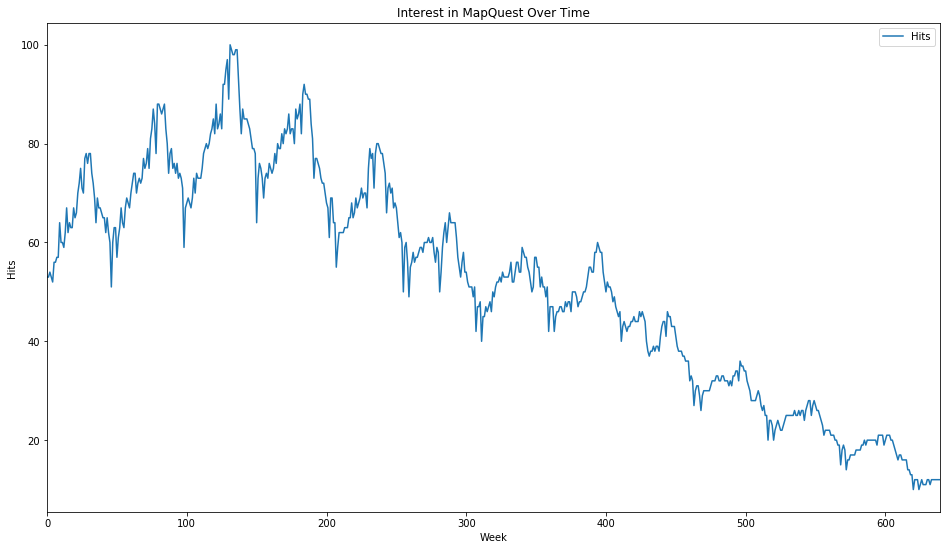

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

# Import the data.
df = pd.read_csv('./datasets/mapquest_google_trends.csv')

# Clean/organize the data. 
df.columns = ['WeekOf', 'Hits']
print(df.head())
plt.rcParams["figure.figsize"] = [16,9]
ax = df.plot(title = "Interest in MapQuest Over Time")
ax.set_xlabel("Week")
ax.set_ylabel("Hits")

Next, we need to compute a coefficient and intercept for our line. NumPy's `polyfit()` method can do this.

Then, define our polynomial function using that coefficient. We can do this on a single dimension using NumPy's `poly1d()` method.

In [2]:
line_coef = np.polyfit(df.index,df['Hits'],1)
print(line_coef)

polynomial = np.poly1d(line_coef)
# The intercept is ~86.59, the slope is ~0.11.

# Let's take a look at the trendline values at specific points:
print(polynomial(0))
print(polynomial(1))

[ -0.10841388  86.58979622]
86.5897962168
86.4813823398


### Now, plot our trendline over the data.

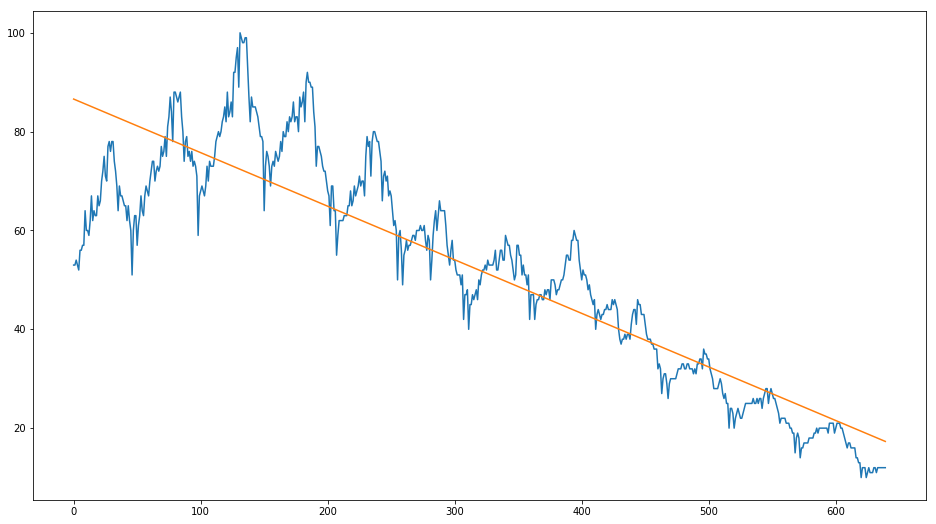

In [3]:
# Plot the time series.
plt.plot(df.index, df['Hits'])
# Plot the least squares minimizing line.
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(df.index, polynomial(df.index));

Looks like a second-order polynomial might fit our data even better. Let's try that out.

In [4]:
line_coef = np.polyfit(df.index,df['Hits'],2)
print(line_coef)

second_polynomial = np.poly1d(line_coef)

[ -1.84964781e-04   9.77861827e-03   7.40219942e+01]


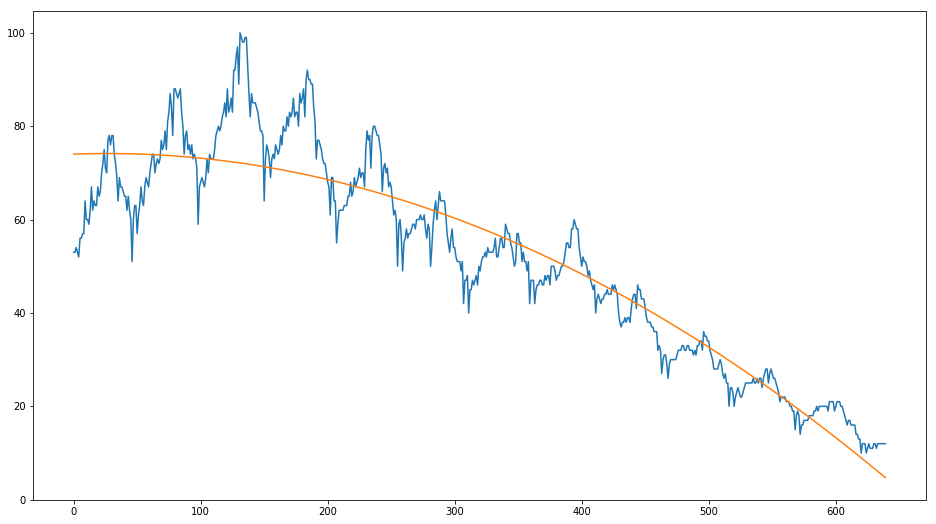

In [5]:
plt.rcParams["figure.figsize"] = [16,9]
# Plot the time series.
plt.plot(df.index, df['Hits'])
# Plot the least squares minimizing line.
plt.plot(df.index, second_polynomial(df.index));

> **Question:** Can you think of any other underlying patterns that might cause trends in time series data? What might cause seasonality in a time series?

### Guided Practice

Let's look for trends and seasonality in data made available by a German drugstore, Rossmann.

These data contain the daily sales made at the drugstore, as well as whether or not a sale or holiday affected the data.

Because we are most interested in the `Date` column (which contains the date of sales for each store), we will make sure to process that as a `datetime` type and make it the index of our DataFrame, as we did with our Apple stock data. 

Let's recall the steps for preprocessing time series data with Pandas:
* Convert time data to a `datetime` object.
* Set `datetime` to index the DataFrame.

In [6]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 8.0)

data = pd.read_csv('./datasets/rossmann.csv', skipinitialspace=True, low_memory=False)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


This allows us to easily filter by date. Let's add a column for `Year` and `Month` based on the `datetime` index. 

In [9]:
data['Year'] = data.index.year
data['Month'] = data.index.month

data['2015-05'].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-05-31,1,7,0,0,0,0,0,0,2015,5
2015-05-31,2,7,0,0,0,0,0,0,2015,5
2015-05-31,3,7,0,0,0,0,0,0,2015,5
2015-05-31,4,7,0,0,0,0,0,0,2015,5
2015-05-31,5,7,0,0,0,0,0,0,2015,5


There are more than a million sales data points in this data set, so, for some simple exploratory data analysis (EDA), we'll focus on just one store.

In [10]:
store1_data = data[data['Store'] == 1].copy()
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


### Plot the sales data.

Let's investigate whether or not promotions affect sales. For this, we'll use boxplots.

On state holidays, the store is closed (which means there are zero sales), so we need to cut those days out. (Contextual knowledge like this is always necessary to truly explain time series phenomena.)

> **Check for Understanding:** Can you think of any other special considerations we should make when tracking sales?

Now, check to see if there is a difference affecting sales on promotion days.

In [18]:
store1_data[store1_data['Open']==0].Promo.value_counts()

0    151
1     10
Name: Promo, dtype: int64

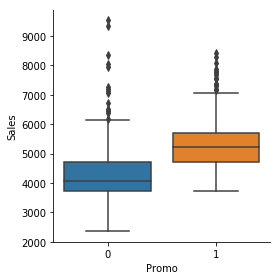

In [17]:
sns.factorplot(
    x='Promo',
    y='Sales',
    data=store1_data[store1_data['Open']==1],
    kind='box'
);

We can see that there *is* a difference in sales on promotion days.

Why is it important to separate out days on which the store is closed? Because there aren't any promotions on those days either, so including them will bias our sales data on days without promotions! Remember to think about the business logic in addition to analyzing the raw data.

We may also want to compare sales across days of the week:

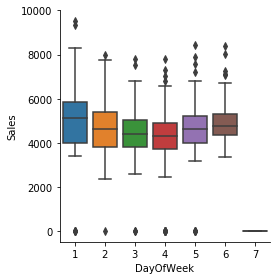

In [19]:
sns.factorplot(
    x='DayOfWeek',
    y='Sales',
    data=store1_data,
    kind='box',
);

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

To plot the sales and customer visits over time:

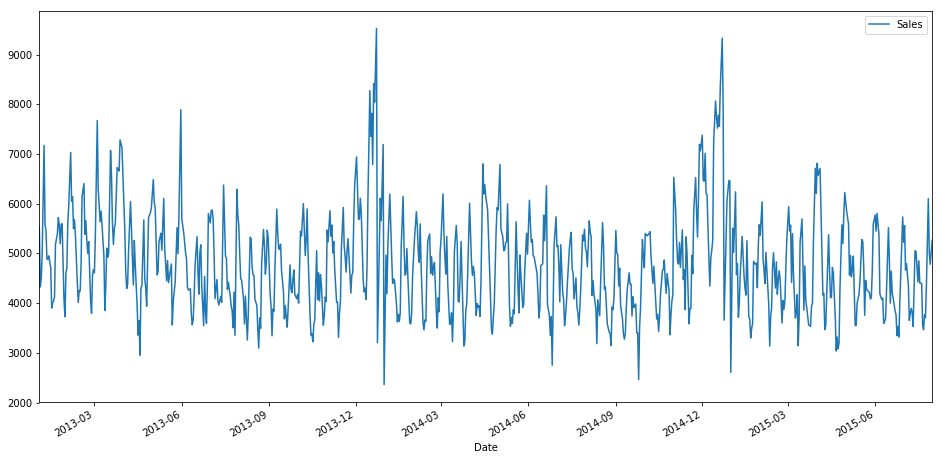

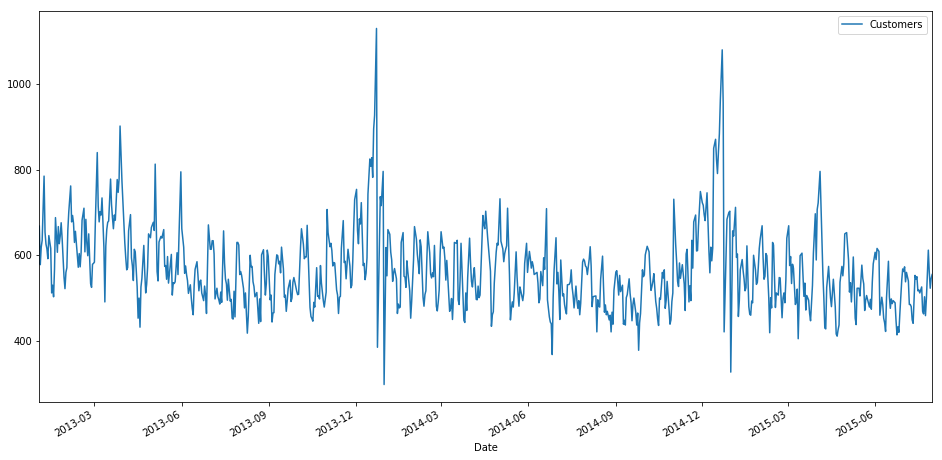

In [20]:
# Filter to days Store 1 was open.
store1_open_data = store1_data[store1_data['Open']==1]
store1_open_data[['Sales']].plot()
store1_open_data[['Customers']].plot();

We can see that there are large spikes of sales and customers toward the end of 2013 and 2014, leading into the first quarter of 2014 and 2015.

Let's use index filtering to filter just to 2015 changes over time. This should make it easier to identify the holiday sales bump.


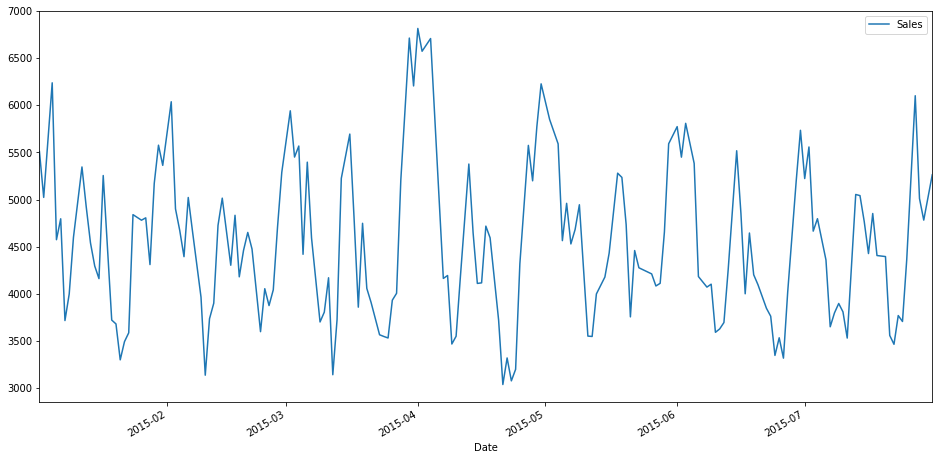

In [21]:
store1_data_2015 = store1_data['2015']
store1_data_2015[store1_data_2015.Open==1][['Sales']].plot();

<h2><a id= "B">Aggregate Data</a></h2>

If we want to investigate trends over time in sales, as always, we'll start by computing simple aggregates. We want to know: What were the mean and median sales in each month and year?

We can use `data.resample` on the whole data set and provide:
- A parameter for the level on which to roll up to: `'D'` for day, `'W'` for week, `'M'` for month, `'A'` for year.
- The aggregation method to perform: `mean()`, `median()`, `sum()`, etc.

In [29]:
data[['Sales']].resample('A').mean()

,Sales
Date,
2013-12-31,5658.533675
2014-12-31,5833.290704
2015-12-31,5878.245380


It looks like average sales were highest in 2015. Now, let's look at the median annual sales.

In [30]:
data[['Sales']].resample('A').median()

,Sales
Date,
2013-12-31,5598
2014-12-31,5794
2015-12-31,5916


In [31]:
data[['Sales']].resample('M').mean()

,Sales
Date,
2013-01-31,5211.555578
2013-02-28,5494.371397
2013-03-31,5820.349168
2013-04-30,5483.749836
2013-05-31,5364.127383
2013-06-30,5402.162960
2013-07-31,6042.062260
2013-08-31,5729.574049
2013-09-30,5322.988430


In [32]:
data[['Sales']].resample('M').median()

,Sales
Date,
2013-01-31,5194.0
2013-02-28,5421.5
2013-03-31,5844.0
2013-04-30,5464.0
2013-05-31,5585.0
2013-06-30,5428.0
2013-07-31,5826.0
2013-08-31,5624.0
2013-09-30,5294.0


For more information, see Pandas' `.resample`  [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html).

> **Question:** How do aggregation techniques help us sort out important insights from the noise of time series data?

<h2><a id = "C">Rolling Statistics</a><h2>

With time series, we can "roll" statistics across time. For example, the rolling mean is the mean of a moving window across time periods. Pandas offers a variety of functionalities for creating rolling statistics, which we'll only scratch the surface of here.

E.g., to understand holidays sales, we don't want to compare sales data in late December with the entire month but instead with a few days immediately surrounding it. We can do this using rolling averages.

The syntax for these can be a little tricky at first. We'll be using a `rolling()` function with a statistical function chained to it. Let's dive into more detail.

### Parameters for `rolling()` Functions

`rolling().mean()` (as well as `rolling().median())` can take the following parameters:

* The first indicates the time series to aggregate.
* `window` indicates the number of periods to include in the average.
* `center` indicates whether the window should be centered on the date or use data prior to that date.

#### Calculate the rolling daily sum over all stores.

Use the `.resample()` function to calculate the daily total over all of the stores.

In [33]:
daily_store_sales = data[['Sales']].resample('D').sum()

Use the `.rolling()` function to calculate the rolling average over a three-day period.

In [34]:
daily_store_sales.rolling(window=3, center=True).mean().head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,4.464961e+06
2013-01-03,6.645534e+06
2013-01-04,6.312789e+06
2013-01-05,4.244817e+06


We can use our index filtering to just look at 2015.

In [35]:
#daily_store_sales.rolling(window=7, center=True).mean()['2015'].head()
# As opposed to this option: 
daily_store_sales['2015'].rolling(window=7, center=True).mean().head()

,Sales
Date,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,NaN
2015-01-04,5.822320e+06
2015-01-05,6.896103e+06


Instead of plotting the full time series, we can plot the rolling mean instead, which smooths random changes in sales and removes outliers, helping us identify larger trends.

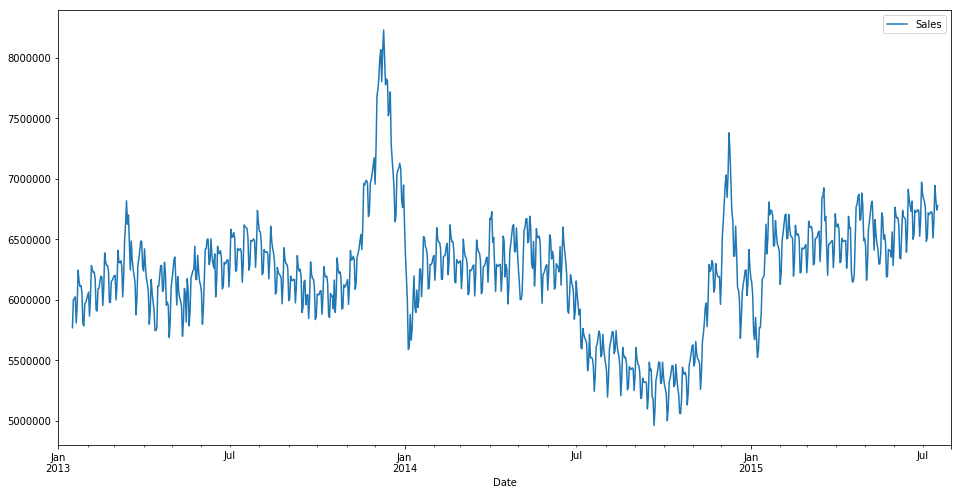

In [36]:
daily_store_sales.rolling(window=30, center=True).mean().plot();

### The Expanding Mean

A common alternative to rolling statistics is to use an expanding window, which yields the value of the statistic with all the data available up to that point in time.

#### Calculate and plot the expanding mean below. Resample by quarter.

In [37]:
rolling_mean = data.Sales.resample('Q').sum().rolling(window=1, center=False).mean()
expanding_mean = data.Sales.resample('Q').sum().expanding().mean()

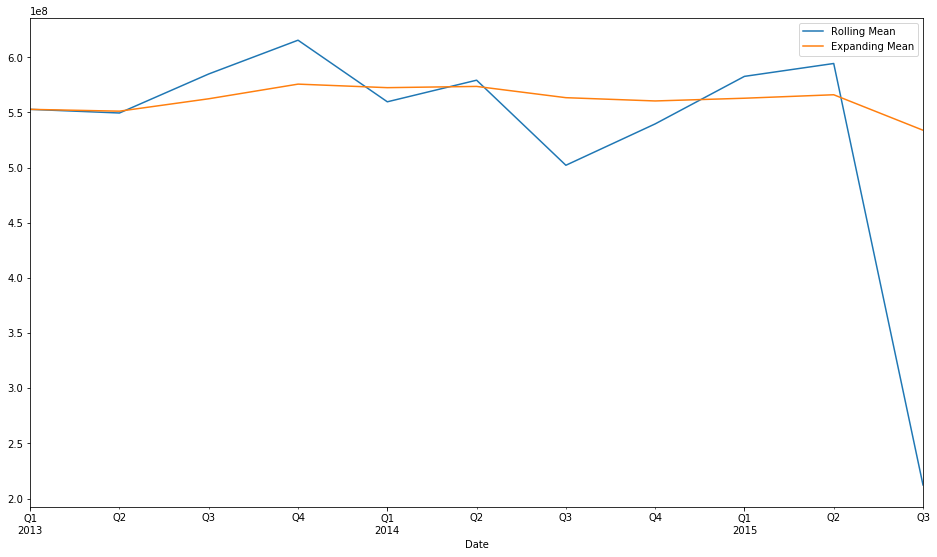

In [38]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.pyplot.subplots()
rolling_mean.plot(legend = True)
expanding_mean.plot(legend = True)
ax.legend(['Rolling Mean', 'Expanding Mean']);

### Exponentially Weighted Windows

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in time series data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of time points that are further in the past.

The (adjusted) exponentially weighted mean for time, $t$, is defined as:

<a id="-xt--fracxt-----alphaxt------alphaxt--------alphatx------alpha-----alpha-------alphat-"></a>
### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

> **Note:** Review Pandas' [documentation](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows) or [Wikipedia](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) for more information.

**Calculate and plot the exponentially weighted sum along with the rolling sum. What's the difference?**

For example: `.resample('Q').sum().ewm(span=10).mean()`.


In [61]:
rolling_mean = data.Sales.resample('Q').sum().rolling(window=2, center=True).mean()
exp_weighted_mean = data.Sales.resample('Q').sum().ewm(span=10).mean()

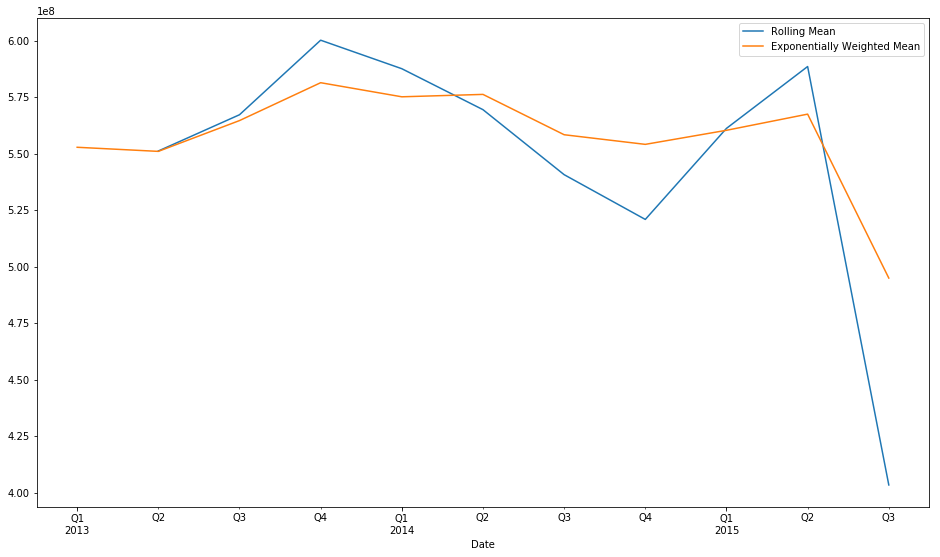

In [62]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.pyplot.subplots()
rolling_mean.plot(legend = True)
exp_weighted_mean.plot(legend = True)
ax.legend(['Rolling Mean', 'Exponentially Weighted Mean']);

*Note that rolling doesn't understand if you are missing periods (e.g., if you roll over three days and your data are missing weekends, it'll roll Fri/Sat/Sun), so you need to resample first if you care about that.*

> **Question:** How does the signal that's captured by rolling statistics differ from the signal captured by resampling time series data?

<h2><a id = "D">Differencing a Time Series and Stationarity</a></h2>

If a time series is stationary, the mean, variance, and autocorrelation (covered in the next section) will be constant over time. Forecasting methods typically assume the time series you are forecasting on to be stationary — or at least approximately stationary.

The most common way to make a time series stationary is through "differencing." This procedure converts a time series into the difference between values.

<a id="-delta-yt--yt---yt--"></a>
### $$ \Delta y_t = y_t - y_{t-1} $$

This removes trends in the time series and ensures that the mean across time is zero. In most cases, this only requires a single difference, although, in some, a second difference (or third, etc.) will be necessary to remove trends.

In [39]:
diff = store1_data['Sales'].diff(periods = 7)

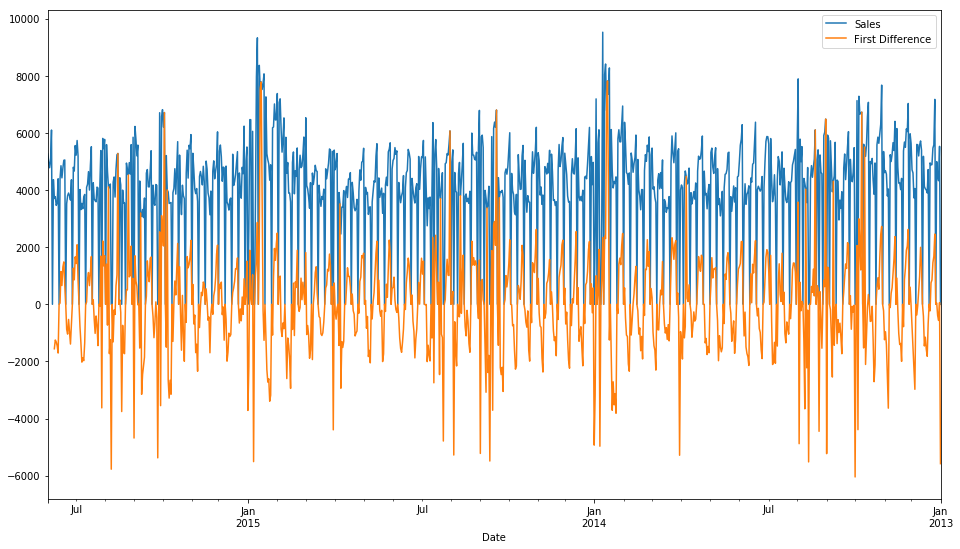

In [40]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.pyplot.subplots()
store1_data['Sales'].plot(legend = True)
diff.plot(legend = True)
ax.legend(['Sales', 'First Difference']);

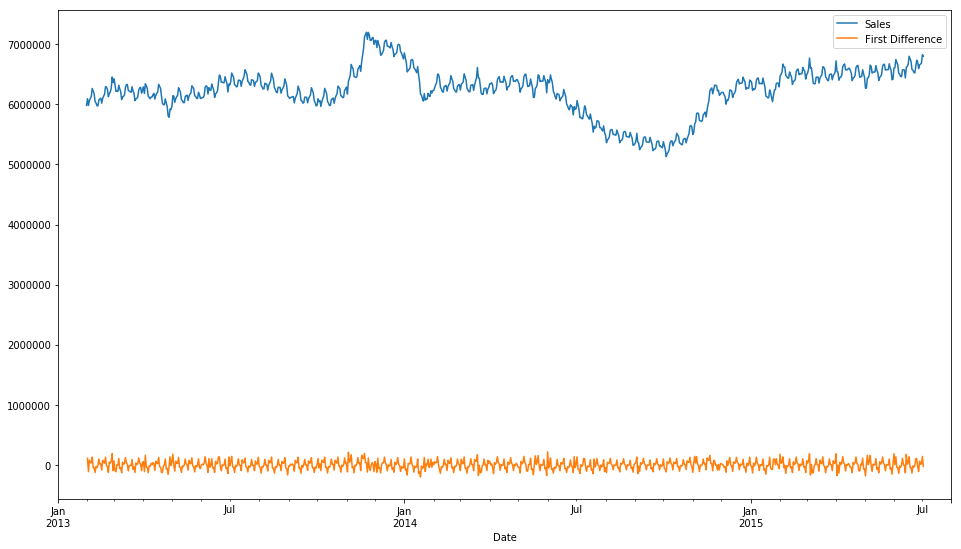

In [41]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.pyplot.subplots()
daily_store_sales.rolling(window=60, center=True).mean().plot(ax = ax, legend = True)
# Change 'periods' below to see effect on difference
daily_store_sales.rolling(window=60, center=True).mean().diff(periods = 1).plot(ax = ax, legend = True)
ax.legend(['Sales', 'First Difference']);

> **Check:** How does differencing help with problems of non-stationarity and autocorrelation in time series data?

<h2><a id="E">Shifting and Lagging Time Series Data</a></h2>

Another common operation on time series data is shifting or lagging values backward and forward in time. This can help us calculate the percentage of change from sample to sample. Pandas has a `.shift()` method for shifting the data in a DataFrame.

Let's take a look at the Rossman data when we apply lagged features. 

In [42]:
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


Let's shift the sales price by one day.

In [43]:
shifted_forward = store1_data.shift(1)
shifted_forward.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,1.0,5.0,5263.0,555.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-29,1.0,4.0,5020.0,546.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-28,1.0,3.0,4782.0,523.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-27,1.0,2.0,5011.0,560.0,1.0,1.0,0,1.0,2015.0,7.0


*Notice that the first row now contains NaN values because there wasn't a previous day's data to shift to that day.*

Next, let's shift the sales prices by five days.

In [44]:
shifted_forward5 = store1_data.shift(5)
shifted_forward5.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-26,1.0,5.0,5263.0,555.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-25,1.0,4.0,5020.0,546.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-24,1.0,3.0,4782.0,523.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-23,1.0,2.0,5011.0,560.0,1.0,1.0,0,1.0,2015.0,7.0


We can also use negative numbers to shift the sales values in the reverse direction.

In [45]:
shifted_backward = store1_data.shift(-1)
shifted_backward.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1.0,4.0,5020.0,546.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-30,1.0,3.0,4782.0,523.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-29,1.0,2.0,5011.0,560.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-28,1.0,1.0,6102.0,612.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-27,1.0,7.0,0.0,0.0,0.0,0.0,0,0.0,2015.0,7.0


Lags can be used to calculate the changes in the values you are tracking with your time series data. In this case, we can use Pandas' `.shift()` method to look at the changes in sales. 

Let's create a new column in our Rossman DataFrame that contains the previous day's sales. 

*Note that we used `.copy()` previously to explicitly tell Pandas that `store1_data` will be a copy and not a view. Here is a useful [video](https://www.youtube.com/watch?v=4R4WsDJ-KVc) that helps explain how to avoid SettingCopyWithWarning errors in Pandas.*

In [46]:
store1_data['Prev Day Sales'] = store1_data['Sales'].shift(1)
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Prev Day Sales
Date,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,NaN
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,5263.0
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,5020.0
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,4782.0
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,5011.0


Using our new column, it's simple to calculate the one-day change in sales at Store 1. Let's create a new column for this value in our DataFrame as well.

In [47]:
store1_data['Sales Change'] = store1_data['Sales'] - store1_data['Prev Day Sales']
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Prev Day Sales,Sales Change
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,NaN,NaN
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,5263.0,-243.0
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,5020.0,-238.0
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,4782.0,229.0
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,5011.0,1091.0


> **Question:** What are some other real-world applications you can think of for shifting data in a time series?

# Recap

* Trends are long-term changes in data. We have to sort through the noise of a time series to identify trends.
* We can resample the data to look at simple aggregates and identify patterns.
* Rolling statistics give us a local statistic of an average in time, smoothing out random fluctuations and removing outliers.

<h2><a id="F">Independent Practice</a></h2>

**Instructor Note**: These are optional and can be undertaken as student practice questions outside of class.

### 1) Load the Unemployment data set. Perform any necessary cleaning and preprocess the data by creating a `datetime` index.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [55]:
unemp = pd.read_csv('./datasets/unemployment.csv')
unemp.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [81]:
unemp = unemp[:-1]
unemp['Quarter'] = pd.to_datetime(unemp.Quarter)
unemp.set_index('Quarter', inplace=True)
unemp.head()

,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
Quarter,
1948-01-01,3.733%
1948-04-01,3.667%
1948-07-01,3.767%
1948-10-01,3.833%
1949-01-01,4.667%


In [83]:
unemp.columns = ['unemp_rate']
unemp.head()

,unemp_rate
Quarter,
1948-01-01,3.733%
1948-04-01,3.667%
1948-07-01,3.767%
1948-10-01,3.833%
1949-01-01,4.667%


In [88]:
unemp['unemp_rate'] = [x.strip('%') for x in unemp.unemp_rate]
unemp.head()

,unemp_rate
Quarter,
1948-01-01,3.733
1948-04-01,3.667
1948-07-01,3.767
1948-10-01,3.833
1949-01-01,4.667


### 2) Plot the unemployment rate.

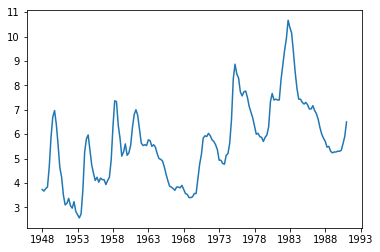

In [90]:
plt.plot(unemp)
plt.show()

### 3) Calculate the rolling mean of years with `window=3 `, without centering, and plot both the unemployment rates and the rolling mean data.

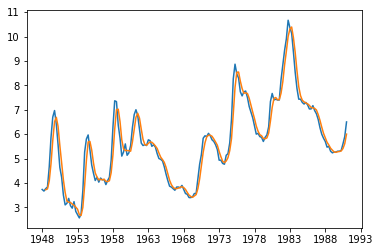

In [91]:
plt.plot(unemp)
plt.plot(unemp.rolling(window=3).mean())
plt.show()

### 4) Calculate the rolling median with `window=5` and `window=15`. Plot both together with the original data.

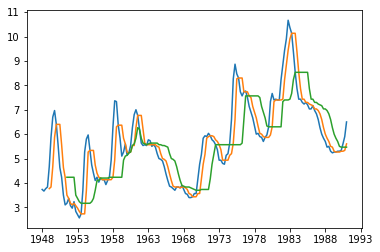

In [92]:
plt.plot(unemp)
plt.plot(unemp.rolling(window=5).median())
plt.plot(unemp.rolling(window=15).median())
plt.show()

### 5) Calculate and plot the expanding mean. Resample by quarter. Plot the rolling mean and the expanding mean together.

### 6) Calculate and plot the exponentially weighted sum along with the rolling sum.

### 7) Difference the unemployment rate and plot.